In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd
import scipy
from scipy.io import loadmat

def marchpast(l, g,sigma):
    "Marchenko-Pastur distribution"
    # input - g determines the shape of the distribution (MP) - sqrt(p/n)
    #         sigma - the scale of the normal distribution
    #         l - points in axis to compute the MP distribution
    # return: the MP distribution for points in l

    def m0(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    gplus=(sigma*(1+g**0.5))**2
    gminus=(sigma*(1-g**0.5))**2
    return np.sqrt(  m0(gplus  - l) *  m0(l- gminus)) / ( 2*np.pi*g*l*(sigma**2))

def generate_alpa_v_vectors(n,p):
    v = np.random.randn(n)
    v /= np.linalg.norm(v)
    # Generate random scalars alpha_i from the standard normal distribution
    a = np.random.randn(p)
    return a,v

def cv(a):

    "Covariance matrix"
    return (np.matmul(a, a.transpose())/a.shape[1])

def randcv(n, p, sigma,a,v):
    """
    # Input:
    # n,p dimension of random matrix
    # sigma - scale of normal distribution
    # s - number of random matrices to generate

    Returns  s covariance matrices
    """

    # # Generate standard random multivariate Gaussian vectors xi
    xi = np.random.randn(n, p)

    x = (a[:, np.newaxis] * v).T + sigma * xi


    x = x-np.mean(x)
    r = cv(x)
    return r

def EE(a, gamma,sigma,to_plot=True):
    "Calculate and show histogram of eigenvalues"

    ee, ev =np.linalg.eigh(a)
    if to_plot:
      nn, bb, patches=plt.hist(ee.ravel(),
                                  bins="auto",
                                  density=True)
      x=np.arange(bb[0], bb[-1], 0.003)
      y = marchpast(x, gamma,sigma)
      return x,y,nn,ee,ev
    return ee, ev


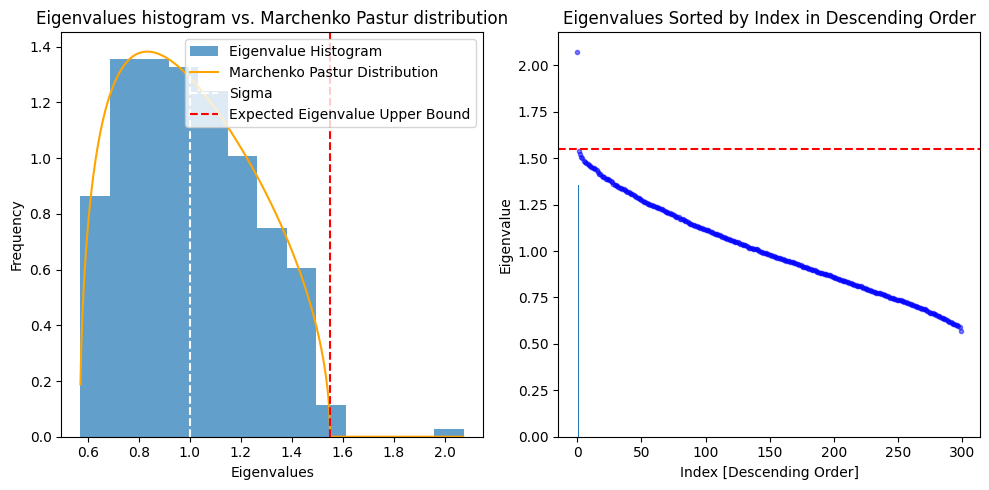

Max Eigenvalue:  2.074336059943055
Upper MP Boundary: 1.5498979485566355


In [3]:
# Set the parameters and 
p = 300
n = 5000
sigma = 1
a,v = generate_alpa_v_vectors(p,n)
r = randcv(p,n,sigma,a,v)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

x, y, nn, ee,ev = EE(r, p/n, sigma)
upper_boundary = (sigma * (1 + (p/n)**0.5))**2


axs[0].hist(ee.ravel(), bins="auto", density=True, alpha=0.7, label='Eigenvalue Histogram')
axs[0].plot(x, y, color='orange',  label='Marchenko Pastur Distribution')
axs[0].axvline(x=sigma, color='white', linestyle='--', label='Sigma')
axs[0].axvline(x=upper_boundary, color='red', linestyle='--', label='Expected Eigenvalue Upper Bound')
axs[0].set_title("Eigenvalues histogram vs. Marchenko Pastur distribution")
axs[0].set_xlabel('Eigenvalues')
axs[0].set_ylabel('Frequency')
axs[0].legend(loc='upper right')
# Scatter plot of eigenvalues against their indices on axs[1]
axs[1].scatter(np.arange(0, len(ee)), np.sort(ee)[::-1], marker='.', color='blue', alpha=0.5)
axs[1].axhline(y=upper_boundary, color='red', linestyle='--', label='Expected Eigenvalue Upper Bound')
axs[1].set_title('Eigenvalues Sorted by Index in Descending Order')
axs[1].set_xlabel('Index [Descending Order]')
axs[1].set_ylabel('Eigenvalue')

plt.tight_layout()
plt.show()
print("Max Eigenvalue: ",np.max(ee))
print("Upper MP Boundary:",upper_boundary)

ניתן לראות שהערך עצמי הגדול ביותר גדול יותר  מהחסם העליון של מצ׳נטו פסטור, ולכן ניתן להסיק כי ניתן לחלץ וקטורים עצמיים משמעותיים וזה אינו הכל תוצאה של רעש.
אכן, לפי איך שבנינו את הדאטא, יש סיגנל אחד מאד משמעותי, ממוסך על ידי רעש. הורדת המימד הצליחה לחלץ את הוקטור המשמעותי, כיוון שהרעש לא דומיננטי ביחד לסיגנל

In [6]:
sigma_lst = np.arange(0, 2.1, 0.2)
v_lv_ip_lst = []
for s in sigma_lst:
  a,v = generate_alpa_v_vectors(p,n)
  r = randcv(p,n,s,a,v)
  ee,ev = EE(r, p/n, s,to_plot = False)
  max_variance_index = np.argmax(ee)

  # Get the corresponding eigenvector
  leading_eigenvector = ev[:, max_variance_index]
  v_lv_ip = np.abs(np.dot(leading_eigenvector, v))
  v_lv_ip_lst.append(v_lv_ip)


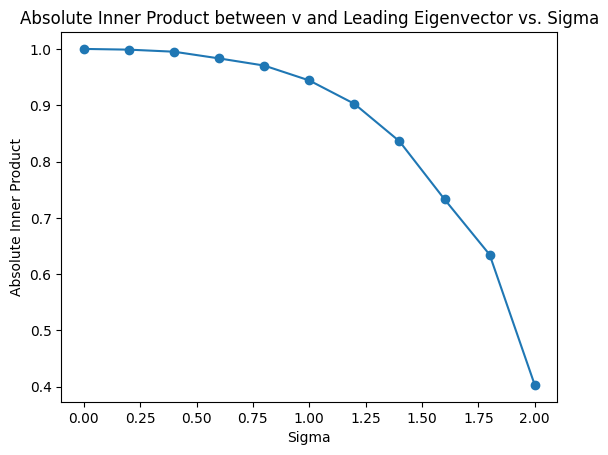

In [7]:
plt.plot(sigma_lst, v_lv_ip_lst, marker='o')
plt.title("Absolute Inner Product between v and Leading Eigenvector vs. Sigma")
plt.xlabel("Sigma")
plt.ylabel("Absolute Inner Product")
plt.show()

בהרצאה הראנו שv
זה הוקטור עצמי עם הערך העצמי הגדול ביותר, זה אומר שהמכפלה הפנימית, כלומר המרחק בניהם שואף ל0, כאשר באמת הוקטור העצמי מצליח להיות לא תוצאה של רעש, כלומר שהצלחנו לתפוס את הסיגנל

אנו יודעים כי המכפלה הפנימינת בין וי לוי שווה ל1 כיוון שהנורמה שווה ל1 וגם הוקטוריםה עצמים האם אורטוגונלים. מכפלה בין וי לוקטורים עצמיים אחרים תהיה 0 מאותה הסיבה.
לכן ניתן לראות שעבור סיגמא 0 - כלומר אין רעש בכלל והמטריצה היא ענן סביב וקטור וי אנו מקבלים שהמכפלה הפנימית היא 1- כלומר אכן הוקטור העצמי המוביל הוא וי, והצלחנו לחלץ את הכיוון עם הכי הרבה שונות שהוא גם משמעותי.
אבל עבור סיגמות גדולות יותר, ניתן לראות שהמכפלה הפנימית יורדת עד שהיא קרובה ל0 - כלומר. הוקטור העצמי הולך ו״נהיה אורטוגונלי״ לוי, כלומר הוקטור העצמי המוביל כבר לא מייצג את הכיוון עם הכי הרבה שונות, אלא הרעש התגבר על הכיוון הזה ולכן נראה שהרעש דומיננטי יותר. זה הגיוני ככל שסיגמא גדלה כיוון שהיא מעצימה את הרעש מול הסיגנל